### Importamos las librerias necesarias

In [ ]:
import cv2, os, shutil
import json
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

from watson_developer_cloud import VisualRecognitionV3
from keras.models import Model, load_model, model_from_json


from myutils import WeightReader, decode_netout, draw_boxes

C:\Users\mvalenca\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Definimos la función que cargará la arquitectura y los pesos de la Red Neuronal

In [ ]:
def set_neural_network(net,weigths):
    """Función que nos permite cargar la Red Neuronal entrenada para el reconocimiento de imágenes.
    Los parametros que acepta son:
    net: String con el nombre del archivo json que tiene la arquitectura de la red.
    weigths: String con el nombre del archivo h5 que contiene los pesos de las conexiones de la red.
    
    La función regresa un modelo de red de Keras."""
    
    with open(net, 'r') as f:            # Se carga la arquitectura de la Red.
        model = model_from_json(f.read())
        
    model.load_weights(weigths)          # Se cargan los pesos de la Red ya entrenada.
    return model

##### Test function

In [ ]:
network = "network_objetos_6.json"
weigths = "weigth_objetos_6.h5"
model = set_neural_network(network, weigths)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 416, 416, 32) 0           norm_1[0][0]                     
__________________________________________________________________________________________________
max_poolin

### Definimos función de Detección de objetos en una fotografía

In [ ]:
def object_detection(foto):
    """Función que nos permite reconocer los objetos que contienen cada una de las fotografías.
    Los parámetros de entrada son:
    foto: String con el nombre de la imagen a analizar.
    
    El modelo regresa un objeto boxes que contiene la información de los objetos detectados."""
    image = cv2.imread(foto)
    dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

    input_image = cv2.resize(image, (416, 416))
    input_image = input_image / 255.
    input_image = input_image[:,:,::-1]
    input_image = np.expand_dims(input_image, 0)

    netout = model.predict([input_image, dummy_array])

    boxes = decode_netout(netout[0], 
                          obj_threshold=0.25, 
                          nms_threshold=NMS_THRESHOLD, 
                          anchors=ANCHORS, 
                          nb_class=CLASS)
    return boxes

##### Test function

In [ ]:
LABELS = ['DIT','ROSETA','MICROFILTRO','DIT_ABIERTO','ENTORCHE','MODEM','ROSETA_VSI','ROSETA_OPTICA']            # Se establecen las clases que se quieren detectar.

IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13 , 13
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.7   #0.5
NMS_THRESHOLD    = 0.3   #0.45
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50

delta = 25

In [ ]:
boxes = object_detection('3701260-1259_1-copia.jpg')

In [ ]:
[LABELS[box.get_label()] for box in boxes]

['ROSETA_OPTICA']

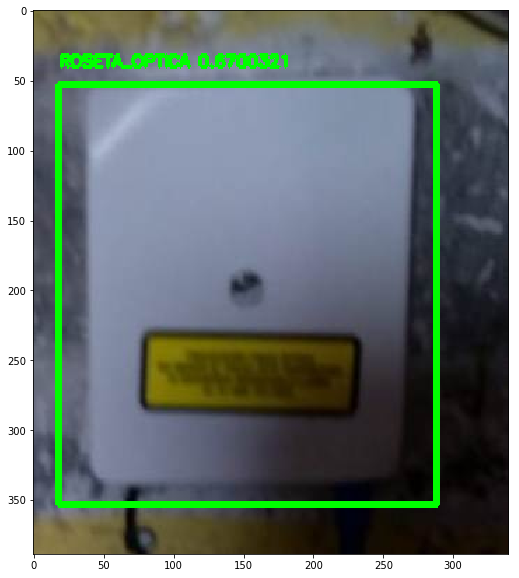

In [ ]:
image = cv2.imread('3701260-1259_1-copia.jpg')
image = draw_boxes(image, boxes, labels=LABELS)
plt.figure(figsize=(10,10))
plt.imshow(image[:,:,::-1]); plt.show()

### Definimos la función de segmentación

In [ ]:
def object_segmentation(foto,directorio,boxes):
    """Función que segmenta cada uno de los objetos detectados en la fotografía por la función object_detection.
    Los parámetros de entrada que se requieren son:
    foto: String con el nombre de la fotografía analizada.
    directorio: String con el nombre del directorio donde guardarán las imagenes segmentadas.
    boxes: Objecto boxes resultado del análisis realizado a la fotografía por la función object_detection.
    
    No regresa nada, pero crean en la carpeta 'directorio' con las imágenes temporales segmentadas de los objetos a evaluar."""
        
    image = cv2.imread(foto)
    image_h, image_w, _ = image.shape

    try:
        os.stat(directorio)
        shutil.rmtree(directorio)
        os.mkdir(directorio)
    except:
        os.mkdir(directorio)

    for box in boxes:
        xmin = max(0, int(box.xmin * image_w) - delta)
        ymin = max(0, int(box.ymin * image_h) - delta)
        xmax = min(image_w, int(box.xmax * image_w) + delta)
        ymax = min(image_h, int(box.ymax * image_h) + delta)
        
        crop = image[ymin:ymax, xmin:xmax]

        outfile = directorio + LABELS[box.get_label()] + '_' + str(boxes.index(box)) + '.jpg'
        cv2.imwrite(outfile, crop)

##### Test function

In [ ]:
directorio = 'img_seg/'
object_segmentation('3701260-1259_1-copia.jpg',directorio,boxes)

### Función para enlistar los objetos detectados en la imagen dependiendo de la tecnología

In [ ]:
def lista_objetos_detectados(directorio, tecnologia = 'cobre'):
    """ Función que enlista los objetos detectados en la fotografía y segmentados en 'directorio'.
    Los parámetros que acepta son:
    directorio: String que tiene el nombre del directorio donde se guardan las imagenes segmentadas.
    tecnología: String que indica la tecnología que se está analizando. Por default está definida con el valor 'cobre', 
                pero acepta el valor 'fibra'.
                
    Regresa: En primera posición una lista con los objetos detectados y segmentados. 
    En segundo lugar, un diccionario con keys
    todos los elementos considerados por tecnología, y values un valor booleano dependiendo si se detecto o no el objeto. 
    En tercer lugar, la lista de los nombres de las imágenes segmentadas en 'directorio'."""
    
    lista_imagenes = next(os.walk(directorio))[2]
    
    if tecnologia == 'cobre':
        
        items_dic = {'DIT': False,
                     'ROSETA_MARFIL':False,
                     'ROSETA_GRIS': False,
                     'MICROFILTRO': False,
                     'DIT_ABIERTO': False,
                     'ENTORCHE':False}
        
    elif tecnologia == 'fibra':
        
        items_dic = {'ROSETA_OPTICA': False,
                     'ROSETA_VSI': False}
    else:
        raise ValueError("La tecnología sólo puede ser 'cobre' o 'fibra'.")
        
    for item in items_dic.keys():
        for i, items in enumerate(lista_imagenes):
            if item in items:
                items_dic[item] = True
                
    lista_objetos = [items[0] for items in items_dic.items() if items[1]]
        
    return lista_objetos, items_dic, lista_imagenes

##### Test function

In [ ]:
test_a, test_b, test_c = lista_objetos_detectados(directorio, tecnologia = 'fibra')

print(type(test_a),test_a)
print(type(test_b),test_b)
print(type(test_c),test_c)

<class 'list'> ['ROSETA_OPTICA']
<class 'dict'> {'ROSETA_OPTICA': True, 'ROSETA_VSI': False}
<class 'list'> ['ROSETA_OPTICA_0.jpg']


### Credenciales de IBM Visual Recognition

In [ ]:
visual_recognition = VisualRecognitionV3(
    'VERSION',
    iam_apikey="API_KEY")

### Funciones para evaluar la instalación de cobre

In [ ]:
def evaluacion_dit_sin_fijar(directorio, file, confianza = '0.7'):
    """ Función que llama al modelo de IBM Visual Recognition para evaluar al DIT FIJO.
    Los parametros que acepta son:
    directorio(string): Nombre del directorio donde están las imágenes segmentadas.
    file(string): Nombre de la imagen segmentada que se analizará.
    confianza(string): Valor de confianza umbral para el modelo de IBM Visual Recognition. Por default tiene de una confianza de 0.7.
    
    Regresa: un string con la clasificación de la imagen, respuesta del modelo en Visual Recognition."""
    
    with open(directorio + file, 'rb') as images_file:
        clases = visual_recognition.classify(images_file,
                                             threshold = confianza,
                                             classifier_ids = 'DevxDitxOkxSinxFijar_1104163376'
                                            ).get_result()
    top_class = clases['images'][0]['classifiers'][0]['classes'][0]['class'].upper()  
    
    return top_class
    
def evaluacion_roseta_sin_fijar(directorio, file, confianza = '0.7'):
    """ Función que llama al modelo de IBM Visual Recognition para evaluar a la ROSETA FIJA.
    Los parametros que acepta son:
    directorio(string): Nombre del directorio donde están las imágenes segmentadas.
    file(string): Nombre de la imagen segmentada que se analizará.
    confianza(string): Valor de confianza umbral para el modelo de IBM Visual Recognition. Por default tiene de una confianza de 0.7.
    
    Regresa: un string con la clasificación de la imagen, respuesta del modelo en Visual Recognition."""

    with open(directorio + file, 'rb') as images_file:
        clases = visual_recognition.classify(images_file,
                                             threshold = confianza,
                                             classifier_ids = 'DevxDitxOkxSinxFijar_1104163376'
                                            ).get_result() #CAMBIAR AQUÍ POR EL MODELO DE LA ROSETA
                
    top_class = clases['images'][0]['classifiers'][0]['classes'][0]['class'].upper()
    
    return top_class
    
def evaluacion_dit_abierto(directorio, file, confianza = '0.7'):
    """ Función que llama al modelo de IBM Visual Recognition para evaluar las conexiones internas del DIT ABIERTO.
    Los parametros que acepta son:
    directorio(string): Nombre del directorio donde están las imágenes segmentadas.
    file(string): Nombre de la imagen segmentada que se analizará.
    confianza(string): Valor de confianza umbral para el modelo de IBM Visual Recognition. Por default tiene de una confianza de 0.7.
    
    Regresa: un string con la clasificación de la imagen, respuesta del modelo en Visual Recognition."""

    with open(directorio + file, 'rb') as images_file:
        clases = visual_recognition.classify(images_file,
                                             threshold = confianza,
                                             classifier_ids = 'DevxDitxOkxSinxFijar_1104163376'
                                            ).get_result() #CAMBIAR AQUÍ POR EL MODELO DEL DIT ABIERTO
                
    top_class = clases['images'][0]['classifiers'][0]['classes'][0]['class'].upper()
    
    return top_class

##### Test function

In [ ]:
evaluacion_roseta_sin_fijar(directorio, test_c[1])

IndexError: list index out of range

### Funciones para evaluar la instalación de fibra

In [ ]:
def evaluacion_roseta_optica_fija(directorio,file, confianza = '0.7'):
    """ Función que llama al modelo de IBM Visual Recognition para evaluar a la ROSETA OPTICA FIJA.
    Los parametros que acepta son:
    directorio(string): Nombre del directorio donde están las imágenes segmentadas.
    file(string): Nombre de la imagen segmentada que se analizará.
    confianza(string): Valor de confianza umbral para el modelo de IBM Visual Recognition. Por default tiene de una confianza de 0.7.
    
    Regresa: un string con la clasificación de la imagen, respuesta del modelo en Visual Recognition."""
    
    with open(file, 'rb') as images_file:
        clases = visual_recognition.classify(images_file,
                                             threshold = confianza,
                                             classifier_ids = 'DevxRosetaxFibraxEtiqueta_1786824475'
                                            ).get_result()
        
    top_class = clases['images'][0]['classifiers'][0]['classes'][0]['class'].upper()
    
    return top_class
    
def evaluacion_roseta_optica_etiqueta(directorio, file, confianza = '0.7'):
    """ Función que llama al modelo de IBM Visual Recognition para evaluar la presencia de ETIQUETA en la ROSETA OPTICA.
    Los parametros que acepta son:
    directorio(string): Nombre del directorio donde están las imágenes segmentadas.
    file(string): Nombre de la imagen segmentada que se analizará.
    confianza(string): Valor de confianza umbral para el modelo de IBM Visual Recognition. Por default tiene de una confianza de 0.7.
    
    Regresa: un string con la clasificación de la imagen, respuesta del modelo en Visual Recognition."""
    
    with open(file, 'rb') as images_file:
        clases = visual_recognition.classify(images_file,
                                             threshold = confianza,
                                             classifier_ids = 'DevxRosetaxFibraxEtiqueta_1786824475'
                                            ).get_result()
    
    top_class = clases['images'][0]['classifiers'][0]['classes'][0]['class'].upper()
        
    return top_class
    
def evaluacion_roseta_alreves(directorio,file, confianza = '0.7'):
    """ Función que llama al modelo de IBM Visual Recognition para evaluar que la ROSETA OPTICA NO ESTÁ AL REVÉS.
    Los parametros que acepta son:
    directorio(string): Nombre del directorio donde están las imágenes segmentadas.
    file(string): Nombre de la imagen segmentada que se analizará.
    confianza(string): Valor de confianza umbral para el modelo de IBM Visual Recognition. Por default tiene de una confianza de 0.7.
    
    Regresa: un string con la clasificación de la imagen, respuesta del modelo en Visual Recognition."""
    
    with open(file, 'rb') as images_file:
        clases = visual_recognition.classify(images_file,
                                             threshold = confianza,
                                             classifier_ids = 'DevxRosetaxFibraxEtiqueta_1786824475'
                                            ).get_result()
        
    top_class = clases['images'][0]['classifiers'][0]['classes'][0]['class'].upper()
    
    return top_class
    
def evaluacion_roseta_optica_jumper(directorio, file, confianza = '0.7'):
    """ Función que llama al modelo de IBM Visual Recognition para evaluar al JUMPER ÓPTICO.
    Los parametros que acepta son:
    directorio(string): Nombre del directorio donde están las imágenes segmentadas.
    file(string): Nombre de la imagen segmentada que se analizará.
    confianza(string): Valor de confianza umbral para el modelo de IBM Visual Recognition. Por default tiene de una confianza de 0.7.
    
    Regresa: un string con la clasificación de la imagen, respuesta del modelo en Visual Recognition."""

    with open(file, 'rb') as images_file:
        clases = visual_recognition.classify(images_file,
                                             threshold = confianza,
                                             classifier_ids='DevxRosetaxFibraxEtiqueta_1786824475'
                                            ).get_result()
    
    top_class = clases['images'][0]['classifiers'][0]['classes'][0]['class'].upper()
    
    return top_class

##### Test function

In [ ]:
evaluacion_roseta_optica_etiqueta(directorio, '3701260-1259_1-copia.jpg')

'CON_ETIQUETA'

###### Definir como guardar los resultados de Visual Recognition por enviarselo a todos a la función de Ponderación

In [ ]:
dict

### Funciones de ponderación según la tecnología

In [ ]:
def ponderacion_cobre(dit_instalado = True, vsi = False):
    """ Función que pondera las respuestas de los modelos de IBM Visual Recognition, para instalaciones de Cobre.
    Los parámetros que acepta son:
    dit_instalado (booleano): variable que nos indica si durante el aprovisionamiento se instaló Dit (True) o no (False). El por default es True
    vsi (booleano): variable que nos indica si se instaló voz por VSI (True)o no (False). El valor default es False.
    
    Respuesta: Un valor númerico (float) que nos índica el porcentaje de la instalación bien realizada."""
    
    ponderacion = 0.0

    if dit_instalado:
        if 'DIT' in items_install_cobre:
            ponderacion += 30.0
        if classes_dit_abierto == DIT_OK:
            ponderacion += 30.0
        if classes_dit_fijo == DIT_OK:
            ponderacion += 15.0
        if classes_roseta_fija == ROSETA_OK:
            ponderacion += 15.0
        if not 'MICROFILTRO' in items_install_cobre:
            ponderacion += 10.0
    else:
        if vsi == False:
            if roseta_marfil == ROSETA_OK:
                ponderacion += 37.5
            if roseta_gris == ROSETA_OK:
                ponderacion += 37.5
            if 'MICROFILTRO' in items_install_cobre:
                ponderacion += 25.0
        else:
            if roseta_gris == ROSETA_OK:
                ponderacion += 60.0
            if 'MICROFILTRO' in items_install_cobre:
                ponderacion += 40.0
            
    return ponderacion

def ponderacion_fibra(test = False):
    """ Función que pondera las respuestas de los modelos de IBM Visual Recognition, para instalaciones de Cobre.
    Los parámetros que acepta son:
    dit_instalado (booleano): variable que nos indica si durante el aprovisionamiento se instaló Dit (True) o no (False). El por default es True
    vsi (booleano): variable que nos indica si se instaló voz por VSI (True)o no (False). El valor default es False.
    
    Respuesta: Un valor númerico (float) que nos índica el porcentaje de la instalación bien realizada."""
    
    ponderacion = 0.0

    if 'ROSETA_OPTICA' in items_install_cobre:
        ponderacion += 42.5
    if classes_roseta_optica_fija == ROSETA_OK:
        ponderacion += 42.5
    if classes_roseta_optica_etiqueta == CON_ETIQUETA:
        ponderacion += 15.0
        
    return ponderacion

In [ ]:
ponderacion_fibra(test = True)

NameError: name 'items_install_cobre' is not defined

In [ ]:
ponderacion = 50

In [ ]:
print('El porcentaje en la instalación es de {}%'.format(ponderacion_resultados(tecnologia='test')))

El porcentaje en la instalación es de 75%


In [ ]:
def respuesta_applex():
    """Función dependiendo de la ponderación, nos permite enviar una respuesta a Applex para que la visualice el técnico.
    Función pendiente de construir dependiendo de la experiencia definida por el equipo de Applex."""
    
    return {"respuesta": "Instalación Éxitosa."}

In [ ]:
respuesta_applex()

{'respuesta': 'Instalación Éxitosa.'}